In [4]:
import numpy as np
import glob
import os
import pandas as pd

def build_lstm_sequences_with_ids_and_seasonality_dual(
    no_fire_folder, fire_folder, sequence_length=12, target_column="chla_mean"
):
    """
    Builds LSTM sequences from two folders: no-fire and fire lakes.
    Adds seasonality (week_sin, week_cos), tracks Lake_ID.
    Filters out any sequence with NaNs.
    Returns separate X/y/lake_ids for both groups.
    """

    def process_folder(folder):
        X_all, y_all, lake_ids = [], [], []

        for file in glob.glob(os.path.join(folder, "Lake_*.csv")):
            df = pd.read_csv(file)
            lake_id = int(df["Lake_ID"].iloc[0])

            # Add seasonal features
            df['week_sin'] = np.sin(2 * np.pi * df['Week'] / 52)
            df['week_cos'] = np.cos(2 * np.pi * df['Week'] / 52)

            # Define predictors (exclude metadata and target)
            predictors = df.columns.difference([
                "Lake_ID", "Year", "Week", "week", "week_start", "week_end", target_column
            ])
            values = df[predictors].values
            targets = df[target_column].values

            for i in range(len(df) - sequence_length + 1):
                x_seq = values[i:i+sequence_length]
                y_val = targets[i+sequence_length - 1]

                if np.isnan(x_seq).any() or np.isnan(y_val):
                    continue

                X_all.append(x_seq)
                y_all.append(y_val)
                lake_ids.append(lake_id)

        return np.array(X_all), np.array(y_all), np.array(lake_ids)

    X_no_fire, y_no_fire, ids_no_fire = process_folder(no_fire_folder)
    X_fire, y_fire, ids_fire = process_folder(fire_folder)

    print(f"✅ No-Fire: {len(X_no_fire)} sequences | Fire: {len(X_fire)} sequences")
    return (X_no_fire, y_no_fire, ids_no_fire), (X_fire, y_fire, ids_fire)






(no_fire_X, no_fire_y, no_fire_ids), (fire_X, fire_y, fire_ids) = build_lstm_sequences_with_ids_and_seasonality_dual(
    no_fire_folder="Datasets/No_Fire_Filtered_LSTM_Input",
    fire_folder="Datasets/Fire_Filtered_LSTM_Input",
    sequence_length=5
)


✅ No-Fire: 262819 sequences | Fire: 73436 sequences


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import os

def normalize_split_with_target_scaling_dual(
    X, y, lake_ids, test_size=0.2, output_dir="lstm_numpy"
):
    """
    Normalizes predictors and standardizes target (CHLA).
    Remaps Lake_IDs, splits train/test, saves to disk.
    """

    # Remap Lake_IDs to contiguous integers
    unique_ids = np.unique(lake_ids)
    id_map = {orig_id: new_id for new_id, orig_id in enumerate(unique_ids)}
    mapped_ids = np.array([id_map[i] for i in lake_ids])

    # Normalize predictors
    n_timesteps, n_features = X.shape[1], X.shape[2]
    X_flat = X.reshape(-1, n_features)
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X_flat).reshape(-1, n_timesteps, n_features)

    # Standardize CHLA target
    y = y.reshape(-1, 1)
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y).ravel()

    # Split into train/test
    X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
        X_scaled, y_scaled, mapped_ids, test_size=test_size, shuffle=True, random_state=42
    )

    # Save to .npy files
    os.makedirs(output_dir, exist_ok=True)
    np.save(os.path.join(output_dir, "X_train.npy"), X_train)
    np.save(os.path.join(output_dir, "X_test.npy"), X_test)
    np.save(os.path.join(output_dir, "y_train.npy"), y_train)
    np.save(os.path.join(output_dir, "y_test.npy"), y_test)
    np.save(os.path.join(output_dir, "lake_ids_train.npy"), ids_train)
    np.save(os.path.join(output_dir, "lake_ids_test.npy"), ids_test)

    print(f"✅ Saved standardized data to: {output_dir}/")
    print(f"Train shape: {X_train.shape}, Target std: mean={y.mean():.2f}, std={y.std():.2f}")
    return X_train, X_test, y_train, y_test, ids_train, ids_test, scaler_X, scaler_y, id_map


X_train, X_test, y_train, y_test, ids_train, ids_test, scaler_X, scaler_y, id_map = normalize_split_with_target_scaling_dual(
    X=fire_X,
    y=fire_y,
    lake_ids=fire_ids,
    output_dir="Datasets/LSTM_Fire"
)


X_train, X_test, y_train, y_test, ids_train, ids_test, scaler_X, scaler_y, id_map = normalize_split_with_target_scaling_dual(
    X=no_fire_X,
    y=no_fire_y,
    lake_ids=no_fire_ids,
    output_dir="Datasets/LSTM_NoFire"
)


✅ Saved standardized data to: Datasets/LSTM_Fire/
Train shape: (58748, 5, 18), Target std: mean=15.29, std=10.77
✅ Saved standardized data to: Datasets/LSTM_NoFire/
Train shape: (210255, 5, 18), Target std: mean=13.03, std=9.59


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import os

def train_and_test_transfer_with_metadata(
    train_dir,
    test_dir,
    model_save_path="model_with_metadata.pth",
    num_epochs=20,
    batch_size=64,
    emb_dim=16,
    hidden_size=64,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load training and test data
    def load_split_data(folder):
        X = np.load(os.path.join(folder, "X_train.npy" if "train" in folder else "X_test.npy"))
        y = np.load(os.path.join(folder, "y_train.npy" if "train" in folder else "y_test.npy"))
        ids = np.load(os.path.join(folder, "lake_ids_train.npy" if "train" in folder else "lake_ids_test.npy"))
        return (
            torch.tensor(X, dtype=torch.float32),
            torch.tensor(y, dtype=torch.float32).unsqueeze(1),
            torch.tensor(ids, dtype=torch.long)
        )

    X_train_t, y_train_t, lake_ids_train_t = load_split_data(train_dir)
    X_test_t, y_test_t, lake_ids_test_t = load_split_data(test_dir)

    train_loader = DataLoader(TensorDataset(X_train_t, lake_ids_train_t, y_train_t), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_t, lake_ids_test_t, y_test_t), batch_size=batch_size, shuffle=False)

    class LSTMWithLakeEmbeddingFusion(nn.Module):
        def __init__(self, input_size, num_lakes, emb_dim=16, hidden_size=64, num_layers=2):
            super().__init__()
            self.embedding = nn.Embedding(num_lakes, emb_dim)
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
            self.fc_lstm = nn.Linear(hidden_size, 32)
            self.fc_emb = nn.Linear(emb_dim, 16)
            self.final = nn.Linear(32 + 16, 1)

        def forward(self, x, lake_id):
            lstm_out, _ = self.lstm(x)
            last_hidden = lstm_out[:, -1, :]  # shape: (batch, hidden_size)
            lake_emb = self.embedding(lake_id)  # shape: (batch, emb_dim)

            lstm_feat = torch.relu(self.fc_lstm(last_hidden))  # (batch, 32)
            emb_feat = torch.relu(self.fc_emb(lake_emb))        # (batch, 16)

            combined = torch.cat([lstm_feat, emb_feat], dim=1)  # (batch, 48)
            return self.final(combined)                         # (batch, 1)


    input_size = X_train_t.shape[2]
    num_lakes = int(max(lake_ids_train_t.max(), lake_ids_test_t.max())) + 1

    model = LSTMWithLakeEmbeddingFusion(input_size, num_lakes, emb_dim, hidden_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for xb, lidb, yb in train_loader:
            xb, lidb, yb = xb.to(device), lidb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb, lidb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss / len(train_loader.dataset):.4f}")

    # Save model with config
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    torch.save({
        "model_state_dict": model.state_dict(),
        "input_size": input_size,
        "num_lakes": num_lakes,
        "emb_dim": emb_dim,
        "hidden_size": hidden_size
    }, model_save_path)

    print(f"✅ Model and metadata saved to: {model_save_path}")
    return model, test_loader, device


# ✅ Example run
model, fire_test_loader, device = train_and_test_transfer_with_metadata(
    train_dir="Datasets/LSTM_NoFire",
    test_dir="Datasets/LSTM_Fire",
    model_save_path="Datasets/LSTM_NoFire/trained_models/chla_lstm_no_fire_with_meta.pth"
)


Using device: cuda
Epoch 1/20 - Loss: 0.7959
Epoch 2/20 - Loss: 0.6380
Epoch 3/20 - Loss: 0.6058
Epoch 4/20 - Loss: 0.5940
Epoch 5/20 - Loss: 0.5872
Epoch 6/20 - Loss: 0.5807
Epoch 7/20 - Loss: 0.5760
Epoch 8/20 - Loss: 0.5701
Epoch 9/20 - Loss: 0.5676
Epoch 10/20 - Loss: 0.5634
Epoch 11/20 - Loss: 0.5597
Epoch 12/20 - Loss: 0.5554
Epoch 13/20 - Loss: 0.5514
Epoch 14/20 - Loss: 0.5501
Epoch 15/20 - Loss: 0.5463
Epoch 16/20 - Loss: 0.5435
Epoch 17/20 - Loss: 0.5395
Epoch 18/20 - Loss: 0.5364
Epoch 19/20 - Loss: 0.5329
Epoch 20/20 - Loss: 0.5299
✅ Model and metadata saved to: Datasets/LSTM_NoFire/trained_models/chla_lstm_no_fire_with_meta.pth


C:\Users\moein\AppData\Local\Temp\ipykernel_18444\3008958872.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


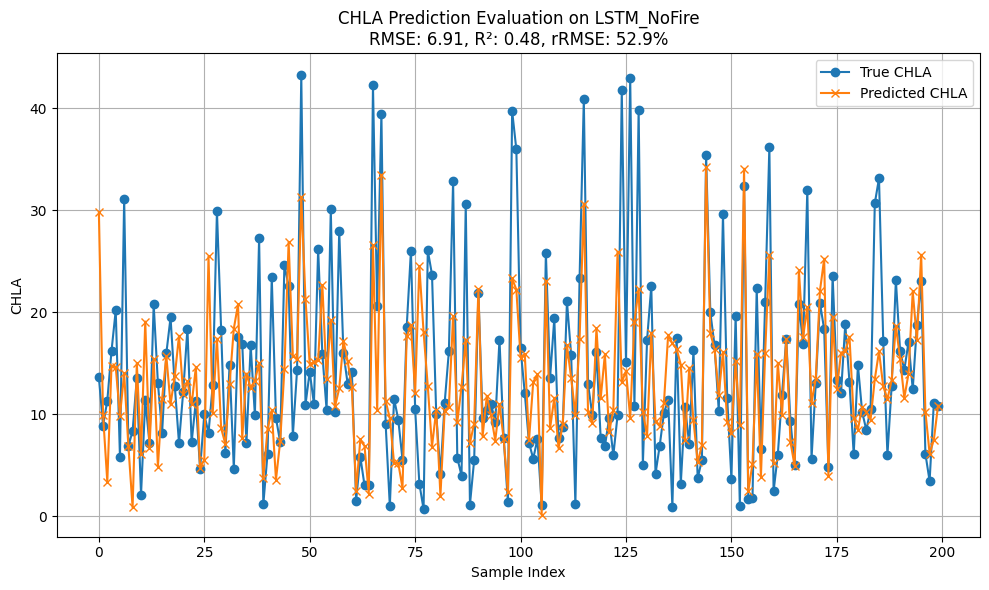

C:\Users\moein\AppData\Local\Temp\ipykernel_18444\3008958872.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


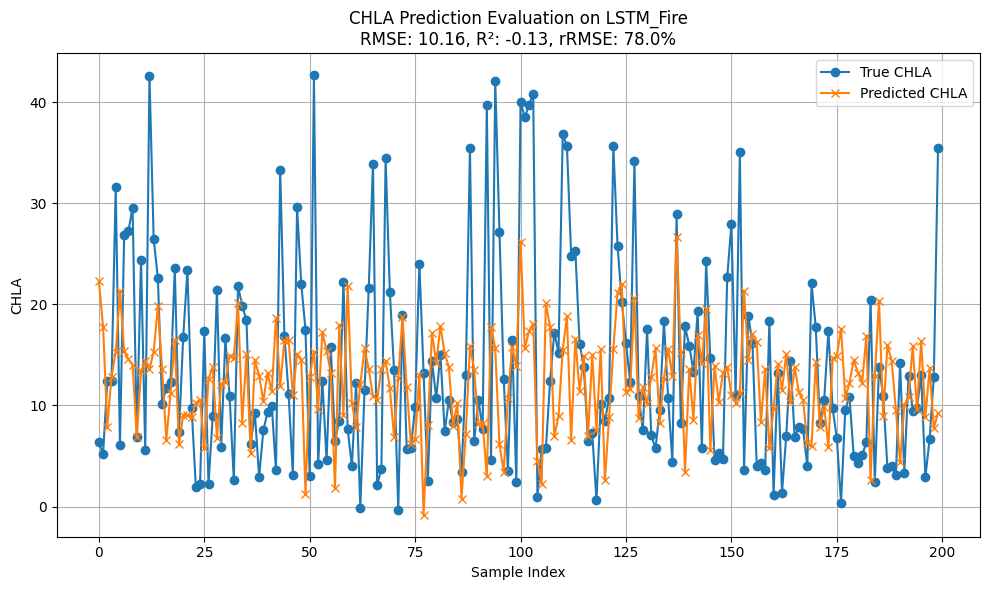

(np.float64(10.164154451087725),
 -0.1256023645401001,
 np.float64(78.00634551232483))

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import os

def evaluate_model_on_test_set(model_path, test_data_folder, scaler_y, batch_size=64, max_batches=None):
    # Load test data
    X_test = np.load(os.path.join(test_data_folder, "X_test.npy"))
    y_test = np.load(os.path.join(test_data_folder, "y_test.npy"))
    lake_ids_test = np.load(os.path.join(test_data_folder, "lake_ids_test.npy"))

    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    lake_ids_test_t = torch.tensor(lake_ids_test, dtype=torch.long)

    test_loader = DataLoader(
        TensorDataset(X_test_t, lake_ids_test_t, y_test_t),
        batch_size=batch_size, shuffle=False
    )

    # Setup model based on test set info
    input_size = X_test.shape[2]
    num_lakes = int(lake_ids_test.max()) + 1

    class LSTMWithLakeEmbeddingFusion(nn.Module):
        def __init__(self, input_size, num_lakes, emb_dim=16, hidden_size=64, num_layers=2):
            super().__init__()
            self.embedding = nn.Embedding(num_lakes, emb_dim)
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
            self.fc_lstm = nn.Linear(hidden_size, 32)
            self.fc_emb = nn.Linear(emb_dim, 16)
            self.final = nn.Linear(32 + 16, 1)

        def forward(self, x, lake_id):
            lstm_out, _ = self.lstm(x)
            last_hidden = lstm_out[:, -1, :]  # shape: (batch, hidden_size)
            lake_emb = self.embedding(lake_id)  # shape: (batch, emb_dim)

            lstm_feat = torch.relu(self.fc_lstm(last_hidden))  # (batch, 32)
            emb_feat = torch.relu(self.fc_emb(lake_emb))        # (batch, 16)

            combined = torch.cat([lstm_feat, emb_feat], dim=1)  # (batch, 48)
            return self.final(combined)                         # (batch, 1)
        

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Load model
    checkpoint = torch.load(model_path)

    input_size = checkpoint["input_size"]
    num_lakes = checkpoint["num_lakes"]
    emb_dim = checkpoint["emb_dim"]
    hidden_size = checkpoint["hidden_size"]

    model = LSTMWithLakeEmbeddingFusion(input_size, num_lakes, emb_dim, hidden_size).to(device)
    model.load_state_dict(checkpoint["model_state_dict"])

    model.eval()


    all_preds = []
    all_targets = []

    with torch.no_grad():
        for i, (xb, lidb, yb) in enumerate(test_loader):
            xb, lidb, yb = xb.to(device), lidb.to(device), yb.to(device)
            preds = model(xb, lidb)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(yb.cpu().numpy())
            if max_batches and i >= max_batches:
                break

    preds_scaled = np.concatenate(all_preds)
    targets_scaled = np.concatenate(all_targets)

    # Inverse scaling
    preds_original = scaler_y.inverse_transform(preds_scaled)
    targets_original = scaler_y.inverse_transform(targets_scaled)

    # Evaluation metrics
    rmse = np.sqrt(mean_squared_error(targets_original, preds_original))
    r2 = r2_score(targets_original, preds_original)
    rrmse = (rmse / np.mean(targets_original)) * 100

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(targets_original[:200], label="True CHLA", marker="o")
    plt.plot(preds_original[:200], label="Predicted CHLA", marker="x")
    plt.title(f"CHLA Prediction Evaluation on {os.path.basename(test_data_folder)}\nRMSE: {rmse:.2f}, R²: {r2:.2f}, rRMSE: {rrmse:.1f}%")
    plt.xlabel("Sample Index")
    plt.ylabel("CHLA")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return rmse, r2, rrmse


# For No-Fire lakes
evaluate_model_on_test_set(
    model_path="Datasets/LSTM_NoFire/trained_models/chla_lstm_no_fire_with_meta.pth",
    test_data_folder="Datasets/LSTM_NoFire",
    scaler_y=scaler_y
)

# For Fire lakes
evaluate_model_on_test_set(
    model_path="Datasets/LSTM_NoFire/trained_models/chla_lstm_no_fire_with_meta.pth",
    test_data_folder="Datasets/LSTM_Fire",
    scaler_y=scaler_y
)



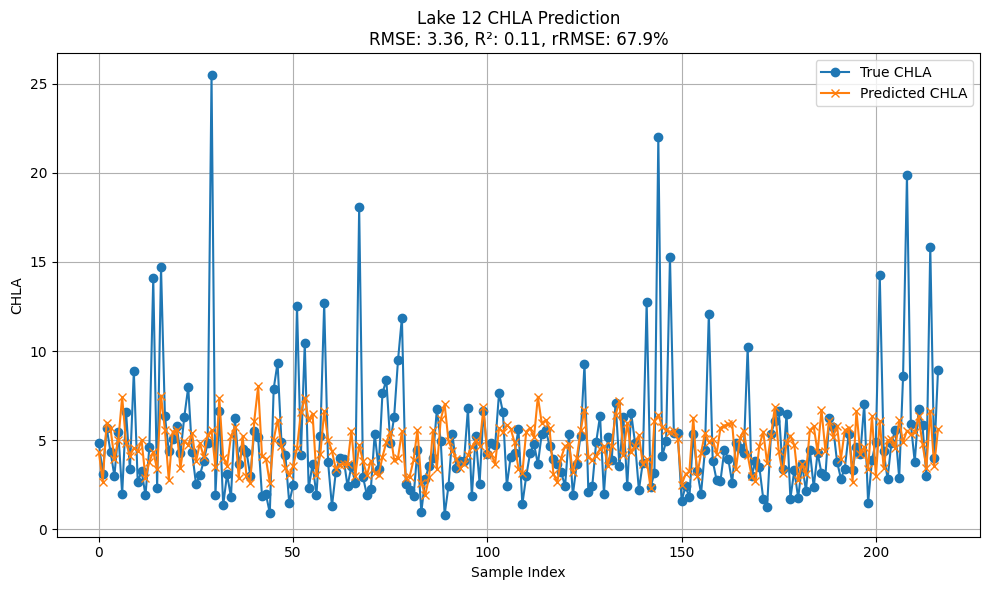

In [32]:
def plot_lake_predictions_with_rrmse(lake_original_id, model, X_test, y_test, lake_ids_test, id_map, scaler_y, device):
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error, r2_score

    model.eval()

    # Map original lake ID to remapped index
    lake_index = id_map.get(lake_original_id)
    if lake_index is None:
        print(f"Lake ID {lake_original_id} not found in id_map.")
        return

    # Select samples for this lake
    indices = np.where(lake_ids_test == lake_index)[0]
    if len(indices) == 0:
        print(f"No test samples found for Lake ID {lake_original_id}.")
        return

    X_lake = torch.tensor(X_test[indices], dtype=torch.float32).to(device)
    lake_ids_tensor = torch.tensor([lake_index] * len(indices), dtype=torch.long).to(device)
    y_true_scaled = y_test[indices]

    with torch.no_grad():
        y_pred_scaled = model(X_lake, lake_ids_tensor).cpu().numpy()

    # Inverse transform CHLA
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    y_true = scaler_y.inverse_transform(y_true_scaled.reshape(-1, 1)).ravel()


    # Metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mean_true = y_true.mean()
    rrmse = (rmse / mean_true) * 100

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label="True CHLA", marker='o')
    plt.plot(y_pred, label="Predicted CHLA", marker='x')
    plt.title(f"Lake {lake_original_id} CHLA Prediction\nRMSE: {rmse:.2f}, R²: {r2:.2f}, rRMSE: {rrmse:.1f}%")
    plt.xlabel("Sample Index")
    plt.ylabel("CHLA")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return rmse, r2, rrmse

rmse, r2, rrmse = plot_lake_predictions_with_rrmse(
    12, model, X_test, y_test, lake_ids_test, id_map, scaler_y, device
)


